##imports

In [2]:
# %pip install pgeocode
# %pip install haversine

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score #Загрузим двеметрики оценки качества
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

import ast

import datetime
from geopy.geocoders import Nominatim
import pgeocode
import re
import copy
import math
from ipywidgets import IntProgress
from IPython.display import display
import haversine as hs
from haversine import Unit

##------------------------GeoSolver----------------------------


In [4]:
class GeoSolver():

    """
    Определяет координаты места по адресу, записанному
    в произвольном виде, а также расстояние между двумя
    точками. Работает только для России и +- нормально
    отработает только на данных для нашей конкретной
    задачи.
    """

    def __init__(self):
        self.__geolocator = Nominatim(user_agent="Tester")
        self.__postal_codes = pgeocode.Nominatim('RU')
        self.__special_words = [ 'г', 'город',
                                 'пос', 'поселок', 'посёлок', 'п',
                                 'с', 'село',
                                 'ст', 'станция',
                                 'м/р', 'месторождение',
                                 'пгт',
                                 'порт', 'аэропорт',
                                 'район',
                                 'обл', 'область',
                                 'регион', 'р', 'округ', 'республика', 'респ'
                                 ]

    def find_distance(self, loc1, loc2):
        """
        (широта, долгота)
        возвращает расстояние по прямой в км
        """
        return hs.haversine(loc1, loc2, unit=Unit.KILOMETERS)


    def check_by_special_name(self, words, name, ident = -1):
        """
        words: список из отдельных слов, составляющих адрес, без пробелов и знаков препинания
        names: опозновательные слова: "г", "город", и т.д.
        ident: в каких пределах ищем имя
        return: позицию по широте и долготе или None
        """
        #print('check_by_special_name', words, names)
        ans = self.find_by_special_name(words, name, ident)
        #print(ans)
        if len(ans) > 0:
            for q in ans:
                query = 'Россия' + ', ' + name + ' ' + q
                #print(f'check: {query}')
                ans = self.location_by_query(query)
                if ans is not None:
                    return ans


    def find_by_special_name(self, words, name, ident = -1):
        """
        words: the list of separated words where to find name
        names_list: list of possible special names
        ident: where to search for the name: before or after the special word, +1 or -1
        or any possible integer. The program will return all the words in the gap,
        for example for ident = -2 two words will be returned
        returns the whole name without the special word
        """
        #print('find_by_special_name')
        #print(f'names_list: {name}, {ident}')
        query = []
        for i, el in enumerate(words):
            if name == el:
                #print(f'>found {name} in words')
                q = []
                #print(f'i: {i}, ident = {ident}')
                left, right = min(i+1 if i+1 < len(words) else len(words)-1, (i+ident if i+ident >= 0 else 0)), \
                              max(i-1 if i-1 >= 0 else 0, (i+ident if i+ident < len(words) else len(words)-1))
                #print(f'>> [{left}; {right}]')
                while left < right:
                    q.append(words[left])
                    left += 1
                #print(q)
                if len(q) > 0:
                    query.append(''.join(q))
        return query


    def location_by_query(self, query):
        #print('location_by_query', query)
        try:
            location = self.__geolocator.geocode(query)
            if location is not None:
                return [location.latitude, location.longitude]
        except:
            print(f'Ошибка! {query}')
        return None


    def find_by_postal_code(self, postal_code, country = 'RU'):
        """
        postal code: str
        country: str, eg 'RU', 'US' (see pgeocode)
        returns latitude and longitude or None
        """
        #print('find_by_postal_code')
        ans = None
        try:
            ans = self.__postal_codes.query_postal_code(postal_code)
        except:
            print(f'Ошибка! postal_code: {postal_code}')
        if ans is None:
            return ans
        lat, lon = ans['latitude'], ans['longitude']
        return [lat, lon]


    def find_coords(self, adress):
        """
        adress: строка. Адрес записан в произвольном формате
        returns: [широта, долгота]
        """
        #print(adress)

        # Возможно, у нас будет несколько вариантов для координат
        lat, lon, postal_code = 0, 0, 0

        #Давайте попытаемся разбить адрес на "слова"
        adr = adress.lower()
        words = re.findall('\w+', adr)
        #print(words)

        #Теперь погнали искать почтовый индекс РФ - 6 цифр
        #Делаем это в первую очередь из-за вида данных
        for el in words:
            if el.isdigit() and len(el) == 6:
                postal_code = el
                ans = self.find_by_postal_code(postal_code)
                # Если мы нашли координаты по почтовому индексу,
                # мы вряд ли найдем что-то лучше
                if (ans[0] is not None) and \
                    (ans[1] is not None) and \
                    (not np.isnan(ans[0]) and not np.isnan(ans[1])):
                    return ans, 1.

        # Почтовый индекс мы не нашли, или по нему ничего нет
        # Дела наши плохи и плачевны, будем тыркать систему запросами

        # Для начала давайте попробуем найти по ключевым словам в порядке
        # убывания точности запроса
        for name in self.__special_words:
            #print(f'------- ident in find_coords: {i}')
            for i in [-2, -1, 1, 2]:
                ans = self.check_by_special_name(words, name, i)
                if ans is not None:
                    return ans, 0.5

        # Дела совсем плохи, давайте попробуем найти по отдельным
        # словам, может что-то получится
        # Идем с конца, так как более точные данные обычно
        # лежат в конце
        for el in words[::-1]:
            ans = self.location_by_query(el)
            if ans is not None:
                return ans, 0.


        return None


    def pd_calc(self, data):
        """
        Обрабатывает данные из pd.DataFrame и возвращает таблицу с доп. колонками
        широтой и долготой, заточена иключительно под нашу задачу (т.е один конкретный
        файл с грузополучателями)
        """
        #coords = pd.DataFrame(columns = ['Код грузополучателя', 'Адрес грузополучателя', 'Долгота', 'Широта'])
        problematic = []
        coords = []
        bar = IntProgress(min=0, max=adresses.shape[0]) # instantiate the bar
        display(bar)                                    # display the bar

        for line, code in zip(data['Адрес грузополучателя'], data['Код грузополучателя']):
            res = self.find_coords(line)
            if res is not None:
                if np.isnan(res[0][0]) or np.isnan(res[0][1]):
                    print(f'WARNING! NaN: {line}')
                coords.append([code, line, res[0][1], res[0][0], res[1]])
            else:
                problematic.append(line)
            bar.value += 1 # signal to increment the progress bar

        coords = pd.DataFrame(coords, columns = ['Код грузополучателя',
                                                 'Адрес грузополучателя', 'Долгота',
                                                 'Широта', 'Уверенность'])
        coords.to_csv('./Data/coords_test.csv', index = False)
        return problematic

## --------------------------------------Prepare data for KMeans-----------------------------





In [ ]:
gruz = pd.read_csv('all_recievers_coords.csv')
gruz['Грузополучатель_адрес'] = gruz['Грузополучатель_адрес'].apply(ast.literal_eval)

def only_coord(adr):
    res = geo_solver.find_coords(adr)
    return res[0]
# gruz["Грузополучатель_адрес"] = gruz["Грузополучатель_адрес"].apply(only_coord)

# Да, будут всплывать WARNINGS
gruz.head(n=5)

,Грузополучатель,Грузополучатель_адрес,reciever_lat,reciever_long
0,2773,"[54.3408, 73.2098]",54.340800,73.209800
1,8536,"[55.00907075000001, 73.29768400924007]",55.009071,73.297684
2,8782,"[55.3353049, 61.3115019]",55.335305,61.311502
3,23908,"[46.19232602727273, 5.996606054545454]",46.192326,5.996606
4,24446,"[43.3620656, 132.8319624]",43.362066,132.831962


In [ ]:
post = pd.read_csv("Справочник_поставщиков_с_единицами_и_нанами.csv")
post = post[post['Город']!="1"]
#там в конце строковая дичь
post.drop(post.tail(4).index,inplace=True)
post['П/индекс'].fillna(post['Город'], inplace=True)

post = post[post['П/индекс'].notna()]
post = post[post['П/индекс']!='EC3N 2AE']
post = post[post['П/индекс']!='AZ 1033'].reset_index(drop=True)
post["Поставщик"] = post["Кредитор"]

post.drop(["Кредитор", "Город"], axis=1, inplace=True)
post.drop("Unnamed: 0", inplace = True, axis=1)


post.info()

<ipython-input-32-25877d655336>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  post = pd.read_csv("Справочник_поставщиков_с_единицами_и_нанами.csv")
<ipython-input-32-25877d655336>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  post['П/индекс'].fillna(post['Город'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206143 entries, 0 to 206142
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   П/индекс   206143 non-null  object
 1   Поставщик  206143 non-null  object
dtypes: object(2)
memory usage: 3.1+ MB


In [ ]:
data = pd.read_csv("template_init_data_for_model_first_month.csv")
# data = data[["Материал", "Грузополучатель", ]]
data['Материал'] = data['Материал'].astype(int)
data['Грузополучатель'] = data['Грузополучатель'].astype(int)
data.reset_index(inplace = True)
# data.info()

In [ ]:
mat_post = pd.read_csv("all_time_material_supplier.csv")
mat_post = mat_post[["Материал", "Класс", "Поставщики"]]
mat_post = mat_post[mat_post['Поставщики'].notna()]
# mat_post.info()

In [ ]:
def get_post(material_id):
    value = mat_post.loc[mat_post["Материал"] == material_id, "Поставщики"]
    return value.iloc[0] if not value.empty and not pd.isna(value.iloc[0]) else np.nan

def get_class(material_id):
    value = mat_post.loc[mat_post["Материал"] == material_id, "Класс"]
    return value.iloc[0] if not value.empty and not pd.isna(value.iloc[0]) else np.nan

# Применяем функцию к каждой строке dataframe1
data["Поставщики"] = data["Материал"].apply(get_post)
data["Класс"] = data["Материал"].apply(get_class)

print(data["index"].nunique())
# Удаляем строки с NaN в новой колонке "value"
result_df = data.dropna(subset=["Поставщики"])
result_df['Поставщики'] = result_df['Поставщики'].apply(ast.literal_eval)
# result_df.info()
#
data = result_df.explode('Поставщики')
data['Поставщик'] = data['Поставщики'].astype(int)
data.drop("Поставщики", inplace = True, axis=1)

data.info()


880
<class 'pandas.core.frame.DataFrame'>
Index: 2423 entries, 0 to 879
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    2423 non-null   int64  
 1   Клиент                   2423 non-null   float64
 2   Материал                 2423 non-null   int64  
 3   Краткий текст материала  2423 non-null   object 
 4   ЕИ                       2423 non-null   object 
 5   Общее количество         2423 non-null   float64
 6   Месяц поставки           2423 non-null   int64  
 7   Год поставки             2423 non-null   int64  
 8   Полугодие                2423 non-null   int64  
 9   Срок поставки            2423 non-null   object 
 10  Грузополучатель          2423 non-null   int64  
 11  Цена                     2423 non-null   float64
 12  Способ закупки           2258 non-null   object 
 13  № заказа                 2423 non-null   int64  
 14  № позиции                2

<ipython-input-35-51b9e95d6ee5>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Поставщики'] = result_df['Поставщики'].apply(ast.literal_eval)


In [ ]:
data["index"].nunique()

861

In [ ]:
def get_addres(id):
    value = post.loc[post["Поставщик"] == id, "П/индекс"]
    return value.iloc[0] if not value.empty and not pd.isna(value.iloc[0]) else np.nan

# Применяем функцию к каждой строке data
data["Поставщик_адрес"] = data["Поставщик"].apply(get_addres)

# data.info()

In [ ]:
def get_addres2(id):
    value = gruz.loc[gruz["Грузополучатель"] == id, "Грузополучатель_адрес"]
    return value.iloc[0] #if (not value.empty and not pd.isna(value.iloc[0])).all() else np.nan

# Применяем функцию к каждой строке dataframe1
data["Грузополучатель_адрес"] = data["Грузополучатель"].apply(get_addres2)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2423 entries, 0 to 879
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    2423 non-null   int64  
 1   Клиент                   2423 non-null   float64
 2   Материал                 2423 non-null   int64  
 3   Краткий текст материала  2423 non-null   object 
 4   ЕИ                       2423 non-null   object 
 5   Общее количество         2423 non-null   float64
 6   Месяц поставки           2423 non-null   int64  
 7   Год поставки             2423 non-null   int64  
 8   Полугодие                2423 non-null   int64  
 9   Срок поставки            2423 non-null   object 
 10  Грузополучатель          2423 non-null   int64  
 11  Цена                     2423 non-null   float64
 12  Способ закупки           2258 non-null   object 
 13  № заказа                 2423 non-null   int64  
 14  № позиции                2423 

In [ ]:
data = data[data['Поставщик_адрес'].notna()]
data = data[data['Грузополучатель_адрес'].notna()]
data.reset_index(drop=True, inplace=True)

In [ ]:
geo_solver = GeoSolver()


In [ ]:
data["Поставщик_адрес"] = data["Поставщик_адрес"].apply(only_coord)

In [ ]:
data['reciever_lat'] = data['Грузополучатель_адрес'].apply(lambda x: x[0])
data['reciever_long'] = data['Грузополучатель_адрес'].apply(lambda x: x[1])
data['supp_lat'] = data['Поставщик_адрес'].apply(lambda x: x[0])
data['supp_long'] = data['Поставщик_адрес'].apply(lambda x: x[1])

In [ ]:
data.head(n=7)

,index,Клиент,Материал,Краткий текст материала,ЕИ,Общее количество,Месяц поставки,Год поставки,Полугодие,Срок поставки,...,Дата заказа,ID Лота,Класс,Поставщик,Поставщик_адрес,Грузополучатель_адрес,reciever_lat,reciever_long,supp_lat,supp_long
0,0,39295.0,770000818063,Кабель FYO2RMU 2х4х4хSML 90756м Nestor,ШТ,2.000,12,2019,2,2019-12-31,...,2020-01-04,1.000003e+11,G2109,55019,"[56.8263, 60.5388]","[52.3445327, 84.4583842]",52.344533,84.458384,56.8263,60.5388
1,1,64025.0,770000594878,"Кабель ИнСил-ОЭвзнг(А)-ХЛ 4х2х1,0-660",КМ,0.695,8,2020,2,2020-08-30,...,2020-01-07,1.000004e+11,G2106,72148,"[56.4464, 58.9183]","[56.7658, 105.6483]",56.765800,105.648300,56.4464,58.9183
2,2,64025.0,770000831667,"Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1",КМ,0.320,10,2020,2,2020-10-10,...,2020-01-07,1.000004e+11,G21050101,44114,"[60.1256, 29.8764]","[56.7658, 105.6483]",56.765800,105.648300,60.1256,29.8764
3,2,64025.0,770000831667,"Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1",КМ,0.320,10,2020,2,2020-10-10,...,2020-01-07,1.000004e+11,G21050101,54948,"[55.7522, 37.6156]","[56.7658, 105.6483]",56.765800,105.648300,55.7522,37.6156
4,3,57650.0,770000869461,"Провод ПуВнг(А)-LS 1х1,0 (PE)",КМ,0.030,8,2020,2,2020-08-30,...,2020-01-10,1.000003e+11,G210511,58691,"[56.8575, 60.6125]","[66.6615094, 66.3810869]",66.661509,66.381087,56.8575,60.6125
5,4,57650.0,770000869463,"Провод ПуГВнг(А)-LS 1х6,0 (PE)",КМ,0.030,8,2020,2,2020-08-30,...,2020-01-10,1.000003e+11,G210511,59541,"[56.5, 84.9667]","[66.6615094, 66.3810869]",66.661509,66.381087,56.5000,84.9667
6,4,57650.0,770000869463,"Провод ПуГВнг(А)-LS 1х6,0 (PE)",КМ,0.030,8,2020,2,2020-08-30,...,2020-01-10,1.000003e+11,G210511,44114,"[60.1256, 29.8764]","[66.6615094, 66.3810869]",66.661509,66.381087,60.1256,29.8764


In [ ]:
def find_dist(x , y):
    return geo_solver.find_distance(x, y)

data["distance"] = data.apply(lambda row: find_dist(row['Поставщик_адрес'], row['Грузополучатель_адрес']), axis=1)
data.head().T

,0,1,2,3,4
index,0,1,2,2,3
Клиент,39295.0,64025.0,64025.0,64025.0,57650.0
Материал,770000818063,770000594878,770000831667,770000831667,770000869461
Краткий текст материала,Кабель FYO2RMU 2х4х4хSML 90756м Nestor,"Кабель ИнСил-ОЭвзнг(А)-ХЛ 4х2х1,0-660","Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1","Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1","Провод ПуВнг(А)-LS 1х1,0 (PE)"
ЕИ,ШТ,КМ,КМ,КМ,КМ
Общее количество,2.0,0.695,0.32,0.32,0.03
Месяц поставки,12,8,10,10,8
Год поставки,2019,2020,2020,2020,2020
Полугодие,2,2,2,2,2
Срок поставки,2019-12-31,2020-08-30,2020-10-10,2020-10-10,2020-08-30


In [ ]:
data.drop(columns=['Поставщик_адрес'], inplace=True)
data.drop(columns=['Грузополучатель_адрес'], inplace=True)

In [ ]:
result = data.loc[data.groupby('index')['distance'].idxmin()]
# result.to_csv("data_for_KMeans.csv", index=False)

In [ ]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 2421
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    860 non-null    int64  
 1   Клиент                   860 non-null    float64
 2   Материал                 860 non-null    int64  
 3   Краткий текст материала  860 non-null    object 
 4   ЕИ                       860 non-null    object 
 5   Общее количество         860 non-null    float64
 6   Месяц поставки           860 non-null    int64  
 7   Год поставки             860 non-null    int64  
 8   Полугодие                860 non-null    int64  
 9   Срок поставки            860 non-null    object 
 10  Грузополучатель          860 non-null    int64  
 11  Цена                     860 non-null    float64
 12  Способ закупки           794 non-null    object 
 13  № заказа                 860 non-null    int64  
 14  № позиции                860 n

In [ ]:
shab = pd.read_csv("template_init_data_for_model_first_month.csv")
shab.info()
# for col in shab.columns:
#     print(col, shab[col].nunique())

Клиент 12
Материал 475
Краткий текст материала 449
ЕИ 5
Общее количество 437
Месяц поставки 11
Год поставки 4
Полугодие 2
Срок поставки 73
Грузополучатель 19
Цена 575
Способ закупки 2
№ заказа 89
№ позиции 347
Дата заказа 20
ID Лота 92


,Клиент,Материал,Краткий текст материала,ЕИ,Общее количество,Месяц поставки,Год поставки,Полугодие,Срок поставки,Грузополучатель,Цена,Способ закупки,№ заказа,№ позиции,Дата заказа,ID Лота


In [ ]:
newdf = shab.drop_duplicates(subset = ['№ заказа', '№ позиции']).reset_index(drop = True)
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Клиент                   880 non-null    float64
 1   Материал                 880 non-null    int64  
 2   Краткий текст материала  880 non-null    object 
 3   ЕИ                       880 non-null    object 
 4   Общее количество         880 non-null    float64
 5   Месяц поставки           880 non-null    int64  
 6   Год поставки             880 non-null    int64  
 7   Полугодие                880 non-null    int64  
 8   Срок поставки            880 non-null    object 
 9   Грузополучатель          880 non-null    float64
 10  Цена                     880 non-null    float64
 11  Способ закупки           794 non-null    object 
 12  № заказа                 880 non-null    int64  
 13  № позиции                880 non-null    int64  
 14  Дата заказа              8

In [ ]:
# first_month_material_supplier_coordinate = data[['Материал', 'Класс', 'Поставщик', 'supp_lat', 'supp_long']]
# first_month_material_supplier_coordinate.head()
# first_month_material_supplier_coordinate.to_csv("first_month_material_supplier_coordinate.csv", index=False)

In [ ]:
# first_month_material_reciever_coordinate = data[['Материал', 'Класс', 'Грузополучатель', 'reciever_lat', 'reciever_long']]
# first_month_material_reciever_coordinate.head()
# first_month_material_reciever_coordinate.to_csv("first_month_material_reciever_coordinate.csv", index=False)

In [ ]:
# то как был получен результат (интерпретация)
# мб втроить в веб интерпритацию
# материал-классМТР-поставщик

# trying KMeans

### ONLY RECIEVER COORDS

In [ ]:
df = pd.read_csv("data_for_KMeans.csv")
# df.head().T

In [ ]:
# to_fit1 = df[["reciever_lat", "reciever_long"]]

# score = []
# for i in range(2, 16):
#     pipe = Pipeline([
#             ('scaler', StandardScaler()),
#             ('clust', KMeans(i, random_state=42, n_init="auto")),
#             ]).fit(to_fit1)

#     label_pred = pipe.predict(to_fit1)
#     score.append(pipe[1].inertia_)
#     df["id_lot"] = label_pred
#     # print(df["id_lot"].value_counts())
#     # print("       ----------             ")
# plt.plot(np.arange(2,16), score)
# # df.head().T

In [ ]:
to_fit1 = df[["reciever_lat", "reciever_long"]]
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clust', KMeans(8, random_state=42, n_init="auto")),
        ]).fit(to_fit1)

label_pred = pipe.predict(to_fit1)
df["id_lot"] = label_pred

# df.head().T
ans = pd.DataFrame(df.groupby("ID Лота")["id_lot"].mean())
# ans["id_lot"].value_counts()

# df["id_lot"].value_counts()

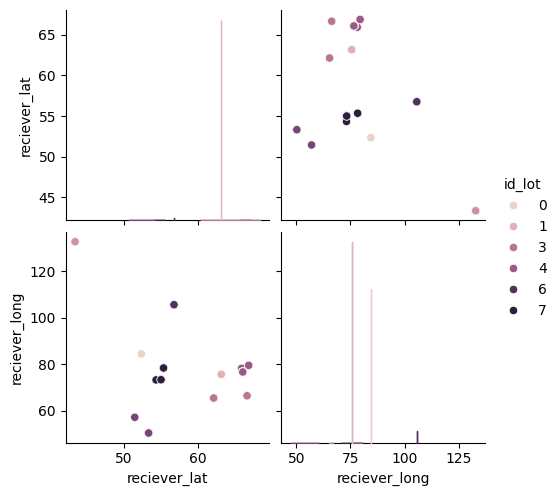

In [ ]:
sns.pairplot(df[["reciever_lat", "reciever_long","id_lot"]], hue='id_lot')

### RECIEVER COORS + DISTANCE

In [ ]:
df = pd.read_csv("data_for_KMeans.csv")
# df.info()

In [ ]:
# to_fit1 = df[["reciever_lat", "reciever_long", "distance"]]

# score = []
# for i in range(2, 16):
#     pipe = Pipeline([
#             ('scaler', StandardScaler()),
#             ('clust', KMeans(i, random_state=42, n_init="auto")),
#             ]).fit(to_fit1)

#     label_pred = pipe.predict(to_fit1)
#     score.append(pipe[1].inertia_)
#     df["id_lot"] = label_pred
#     # print(df["id_lot"].value_counts())
#     # print("       ----------             ")
# plt.plot(np.arange(2,16), score)
# # df.head().T

In [ ]:
to_fit1 = df[["reciever_lat", "reciever_long", "distance"]]
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clust', KMeans(8, random_state=42, n_init="auto")),
        ]).fit(to_fit1)

label_pred = pipe.predict(to_fit1)
df["id_lot"] = label_pred
df["id_lot"].value_counts()
# df.head().T


,count
id_lot,
4,292
1,234
6,130
0,99
5,47
2,25
3,17
7,16


In [ ]:
to_fit1 = df[["reciever_lat", "reciever_long", "distance"]]
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clust', KMeans(4, random_state=42, n_init="auto")),
        ]).fit(to_fit1)

label_pred = pipe.predict(to_fit1)
df["id_lot"] = label_pred
df["id_lot"].value_counts()
# df.head().T

,count
id_lot,
1,656
0,133
3,46
2,25


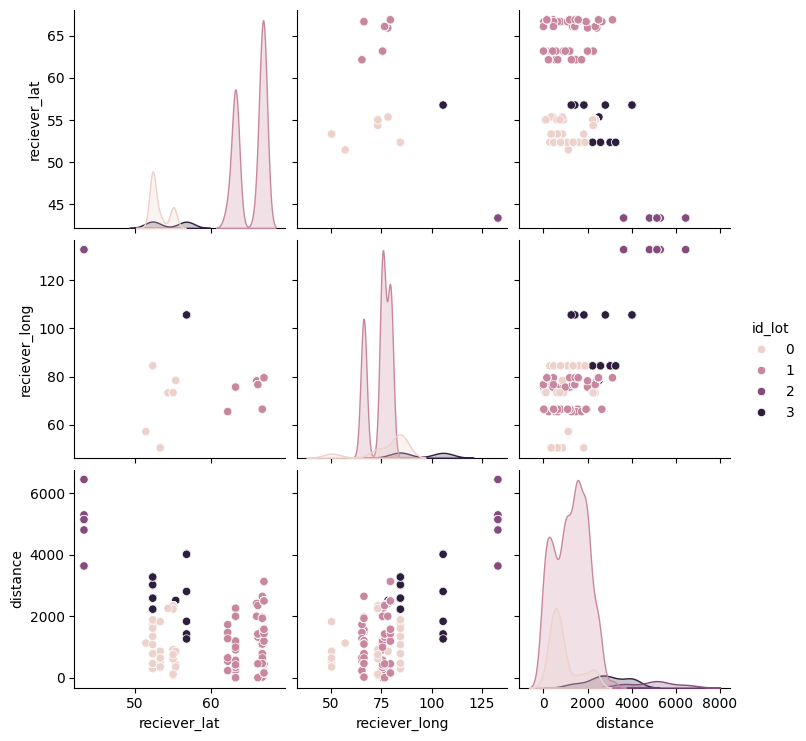

In [ ]:
sns.pairplot(df[["reciever_lat", "reciever_long", "distance", "id_lot"]], hue='id_lot')

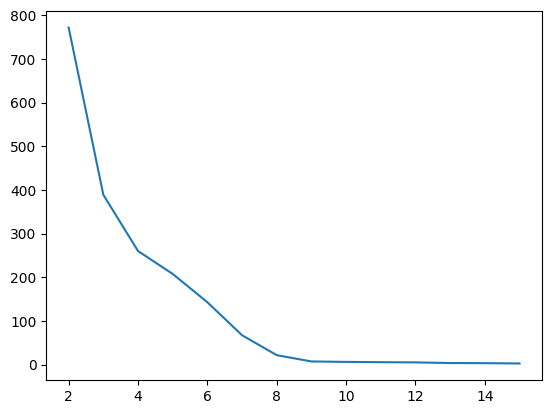

In [ ]:
score = []
for i in range(2, 16):
    to_fit1 = df[["reciever_lat", "reciever_long", "distance"]]

    to_fit1 = pd.DataFrame(StandardScaler().fit_transform(to_fit1), columns=["reciever_lat", "reciever_long", "distance"])
    to_fit1["distance"] *= 0.1

    pipe = Pipeline([
        ('clust', KMeans(i, random_state=42, n_init="auto"))
        ]).fit(to_fit1)

    label_pred = pipe.predict(to_fit1)
    score.append(pipe[0].inertia_)
    df["id_lot"] = label_pred

plt.plot(np.arange(2,16), score)


In [ ]:
to_fit1 = df[["reciever_lat", "reciever_long", "distance"]]

to_fit1 = pd.DataFrame(StandardScaler().fit_transform(to_fit1), columns=["reciever_lat", "reciever_long", "distance"])
to_fit1["distance"] *= 0.5
pipe = Pipeline([
        # ('scaler', StandardScaler()),
        ('clust', KMeans(7, random_state=42, n_init="auto"))
        ]).fit(to_fit1)

label_pred = pipe.predict(to_fit1)
df["id_lot"] = label_pred
df["id_lot"].value_counts()
# df.head().T
ans = pd.DataFrame(df.groupby("ID Лота")["id_lot"].mean())
ans["id_lot"].value_counts()

,count
id_lot,
1.000000,27
0.000000,23
5.000000,13
2.000000,7
4.000000,5
6.000000,3
3.000000,3
1.266667,1
2.500000,1


#lots for seva

In [ ]:
df0 = pd.read_csv("historical_completed_purchases.csv")
df1 = pd.DataFrame(df0[["Клиент", "Материал", "Материал Имя","Базисная ЕИ","Кол-во к закупу, БЕИ",
          "Срок поставки","Грузополучатель","План.цена с НДС","ГПЗ Способ закупки",
          "Заявка на закупку","Позиц.","Дата заявки","ID лота"]])

df1.rename(columns={"Материал Имя": "Краткий текст материала",
                   "Базисная ЕИ": "ЕИ",
                   "Кол-во к закупу, БЕИ": "Общее количество",
                   "План.цена с НДС": "Цена",
                   "ГПЗ Способ закупки": "Способ закупки",
                   "Заявка на закупку": "№ заказа",
                   "Позиц.": "№ позиции",
                   "ID лота": "ID Лота",
                   }, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39530 entries, 0 to 39529
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Клиент                   39525 non-null  float64
 1   Материал                 39530 non-null  int64  
 2   Краткий текст материала  39530 non-null  object 
 3   ЕИ                       39530 non-null  object 
 4   Общее количество         39530 non-null  float64
 5   Срок поставки            39530 non-null  object 
 6   Грузополучатель          39527 non-null  float64
 7   Цена                     39530 non-null  float64
 8   Способ закупки           25253 non-null  object 
 9   № заказа                 39530 non-null  int64  
 10  № позиции                39530 non-null  int64  
 11  Дата заявки              39530 non-null  object 
 12  ID Лота                  30463 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 3.9+ MB


In [ ]:
df = df1[df1['ID Лота'].notna()]
grouped = df.groupby('ID Лота')
grouped.head().T

,0,1,2,3,4,5,6,7,8,9,...,39500,39512,39513,39514,39515,39516,39525,39527,39528,39529
Клиент,39295.0,64025.0,64025.0,57650.0,57650.0,57650.0,57650.0,57650.0,57650.0,57650.0,...,78154.0,37846.0,37846.0,37846.0,37846.0,37846.0,50630.0,78154.0,78154.0,78154.0
Материал,770000818063,770000594878,770000831667,770000869461,770000869463,770000869464,770000848016,770000602743,770000783346,770000893542,...,770000318796,770001014418,770001219838,770001238805,770001305652,770001398495,770000568321,770001534234,770001757817,770000434863
Краткий текст материала,Кабель FYO2RMU 2х4х4хSML 90756м Nestor,"Кабель ИнСил-ОЭвзнг(А)-ХЛ 4х2х1,0-660","Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1","Провод ПуВнг(А)-LS 1х1,0 (PE)","Провод ПуГВнг(А)-LS 1х6,0 (PE)",Провод ПуГВ-ХЛ 1х4 (РЕ),Провод ПуГВ-ХЛ 1х6 (РЕ)-450/750В,"Кабель ИнСил-ОЭвзнг(А)-FRLS-ХЛ 7х1,0-660",Кабель ИнСил-ОЭзнг(А)-LS 4х1-660,"Кабель ИнСил-ОЭвзнг(А)-FRLS-ХЛ 14х1,0",...,Наконечник ТМЛ 10-6-5 КВТ,Кабель U/UTP Eurolan/19C-U6-22WT-B305,Кабель U/UTP Eurolan/19C-U6-12WT-B305,Кабель F/FTP Eurolan/19C-ZA-12WT-R500,Кабель F/UTP Eurolan/19C-F6-05VL-B305,Кабель U/UTP Eurolan/19C-U6-09BL-B305,Провод ПуГВнг(А)-LS 1х25 з-ж,"Кабель ВВГнг(A)-LS 3х1,5ок-1","Кабель ВВГнг(A)-LS 3х2,5-1","Кабель SkyNet/FTP 4х2х0,51 5е in/Cu"
ЕИ,ШТ,КМ,КМ,КМ,КМ,КМ,КМ,КМ,КМ,КМ,...,ШТ,ШТ,ШТ,ШТ,ШТ,ШТ,КМ,КМ,КМ,М
Общее количество,2.0,0.695,0.32,0.03,0.03,0.015,0.02,0.585,0.055,2.958,...,120.0,2.0,35.0,4.0,4.0,3.0,0.15,0.1,0.08,82.0
Срок поставки,2019-12-31,2020-08-30,2020-10-10,2020-08-30,2020-08-30,2020-08-30,2020-08-30,2020-08-25,2020-08-25,2020-08-25,...,2024-07-31,2024-09-30,2024-09-30,2024-09-30,2024-09-30,2024-09-30,2024-08-24,2024-07-31,2024-07-31,2024-07-31
Грузополучатель,20000447.0,20001383.0,20001383.0,20000537.0,20000537.0,20000537.0,20000537.0,20000537.0,20000537.0,20000537.0,...,20001078.0,20001818.0,20001818.0,20001818.0,20001818.0,20001818.0,20000734.0,20001078.0,20001078.0,20001078.0
Цена,6548648.22,690197.32,445302.88,1136400.0,1200000.0,1680000.0,2040000.0,1192050.3,419436.0,2093488.2,...,1.2,21120.0,20724.0,57420.0,29667.0,21207.3,237888.0,81496.0,124582.0,177.54
Способ закупки,NaN,Конкурентный отбор,Конкурентный отбор,Конкурентный отбор,Конкурентный отбор,Конкурентный отбор,Конкурентный отбор,Конкурентный отбор,Конкурентный отбор,Конкурентный отбор,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
№ заказа,10928585,10928863,10928863,10929730,10929730,10929730,10929730,10929730,10929730,10929730,...,11623611,11624277,11624277,11624277,11624277,11624277,11625397,11625929,11625929,11625929


In [ ]:
df.columns

Index(['Клиент', 'Материал', 'Краткий текст материала', 'ЕИ',
       'Общее количество', 'Срок поставки', 'Грузополучатель', 'Цена',
       'Способ закупки', '№ заказа', '№ позиции', 'Дата заявки', 'ID Лота'],
      dtype='object')

In [ ]:
df0 = pd.read_csv("data_for_KMeans.csv")
df0.head()

,index,Клиент,Материал,Краткий текст материала,ЕИ,Общее количество,Месяц поставки,Год поставки,Полугодие,Срок поставки,...,№ позиции,Дата заказа,ID Лота,Класс,Поставщик,reciever_lat,reciever_long,supp_lat,supp_long,distance
0,0,39295.0,770000818063,Кабель FYO2RMU 2х4х4хSML 90756м Nestor,ШТ,2.000,12,2019,2,2019-12-31,...,30,2020-01-04,1.000003e+11,G2109,55019,52.344533,84.458384,56.8263,60.5388,1610.157562
1,1,64025.0,770000594878,"Кабель ИнСил-ОЭвзнг(А)-ХЛ 4х2х1,0-660",КМ,0.695,8,2020,2,2020-08-30,...,50,2020-01-07,1.000004e+11,G2106,72148,56.765800,105.648300,56.4464,58.9183,2804.076031
2,2,64025.0,770000831667,"Кабель К9РВСБПМнг(А)-HF 4х1,5ок(N)-1",КМ,0.320,10,2020,2,2020-10-10,...,60,2020-01-07,1.000004e+11,G21050101,54948,56.765800,105.648300,55.7522,37.6156,4027.129804
3,3,57650.0,770000869461,"Провод ПуВнг(А)-LS 1х1,0 (PE)",КМ,0.030,8,2020,2,2020-08-30,...,210,2020-01-10,1.000003e+11,G210511,58691,66.661509,66.381087,56.8575,60.6125,1130.458240
4,4,57650.0,770000869463,"Провод ПуГВнг(А)-LS 1х6,0 (PE)",КМ,0.030,8,2020,2,2020-08-30,...,220,2020-01-10,1.000003e+11,G210511,69357,66.661509,66.381087,66.0833,76.6333,460.862024


#classes/func

In [ ]:
geo_solver = GeoSolver()
def only_coord(adr):
    res = geo_solver.find_coords(adr)
    return res[0]

# функция для сопоставления Материал -> Поставщики
def get_post(material_id):
    value = mat_post.loc[mat_post["Материал"] == material_id, "Поставщики"]
    return value.iloc[0] if not value.empty and not pd.isna(value.iloc[0]) else np.nan

# функция для сопоставления Материал -> Класс
def get_class(material_id):
    value = mat_post.loc[mat_post["Материал"] == material_id, "Класс"]
    return value.iloc[0] if not value.empty and not pd.isna(value.iloc[0]) else np.nan

# функция для сопоставления Поставщик -> П/индекс
def get_addres(id):
    value = post.loc[post["Поставщик"] == id, "П/индекс"]
    return value.iloc[0] if not value.empty and not pd.isna(value.iloc[0]) else np.nan

# функция для сопоставления Грузополучатель -> Грузополучатель_адрес
def get_addres2(id):
    value = gruz.loc[gruz["Грузополучатель"] == id, "Грузополучатель_адрес"]
    return value.iloc[0]

#надо для удобства
def find_dist(x , y):
    return geo_solver.find_distance(x, y)

In [ ]:
class Preparer:

    @staticmethod
    def preparing_for_KMeans():

        gruz = pd.read_csv('all_recievers_coords.csv')
        gruz['Грузополучатель_адрес'] = gruz['Грузополучатель_адрес'].apply(ast.literal_eval)


        post = pd.read_csv("Справочник_поставщиков_с_единицами_и_нанами.csv")
        #убираем ошибки в данных
        post = post[post['Город']!="1"]

        #там в конце строковая дичь
        post.drop(post.tail(4).index,inplace=True)

        #где нет индекса заполняем городом
        post['П/индекс'] = post['П/индекс'].fillna(post['Город'])

        # убираем тех, кого не можем найти по индексу
        post = post[post['П/индекс'].notna()]

        # парочку иностранцев убираем
        post = post[post['П/индекс']!='EC3N 2AE']
        post = post[post['П/индекс']!='AZ 1033'].reset_index(drop=True)

        # для удоства переименовываем
        post["Поставщик"] = post["Кредитор"]
        post.drop(["Кредитор", "Город", "Unnamed: 0"], axis=1, inplace=True)


        mat_post = pd.read_csv("all_time_material_supplier.csv")
        mat_post = mat_post[["Материал", "Класс", "Поставщики"]]
        mat_post = mat_post[mat_post['Поставщики'].notna()]


        data = pd.read_csv("template_init_data_for_model_first_month.csv")
        data['Материал'] = data['Материал'].astype(int)
        data['Грузополучатель'] = data['Грузополучатель'].astype(int)

        # добавляю индекс, чтобы структурировать заявки
        data.reset_index(inplace = True)

        # Применяем функцию к каждой строке data
        data["Поставщики"] = data["Материал"].apply(get_post)
        data["Класс"] = data["Материал"].apply(get_class)

        # Удаляем строки с NaN в новой колонке "value", если прокрались
        result_df = data.dropna(subset=["Поставщики"])

        # из "объекта" в список, чтобы потом развернуть его
        result_df['Поставщики'] = result_df['Поставщики'].apply(ast.literal_eval)

        # тут для каждого метриала разворачиается список поставщиков, создается новая строка для каждого поставщика
        data = result_df.explode('Поставщики')

        #для удобства
        data['Поставщик'] = data['Поставщики'].astype(int)
        data.drop("Поставщики", inplace = True, axis=1)

        # получаем адрес каждого поставщика
        data["Поставщик_адрес"] = data["Поставщик"].apply(get_addres)

        # получаем адрес каждого Грузополучателя
        data["Грузополучатель_адрес"] = data["Грузополучатель"].apply(get_addres2)

        data = data[data['Поставщик_адрес'].notna()]
        data = data[data['Грузополучатель_адрес'].notna()]
        data.reset_index(drop=True, inplace=True)
        # по адресу находим координаты c помощью GeoSolver inside
        data["Поставщик_адрес"] = data["Поставщик_адрес"].apply(only_coord)

        # расписываем отдельно
        data['reciever_lat'] = data['Грузополучатель_адрес'].apply(lambda x: x[0])
        data['reciever_long'] = data['Грузополучатель_адрес'].apply(lambda x: x[1])
        data['supp_lat'] = data['Поставщик_адрес'].apply(lambda x: x[0])
        data['supp_long'] = data['Поставщик_адрес'].apply(lambda x: x[1])

        # считаем расстояние между грузополуч и пост
        data["distance"] = data.apply(lambda row: find_dist(row['Поставщик_адрес'], row['Грузополучатель_адрес']), axis=1)
        result = data.loc[data.groupby('index')['distance'].idxmin()]

        result.info()
        result.to_csv("data_for_KMeans.csv", index=False)
        print("data saved to 'data_for_KMeans.csv'")


In [ ]:
pr = Preparer()
pr.preparing_for_KMeans()

<ipython-input-51-a6da82495b47>:10: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  post = pd.read_csv("Справочник_поставщиков_с_единицами_и_нанами.csv")
<ipython-input-51-a6da82495b47>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['Поставщики'] = result_df['Поставщики'].apply(ast.literal_eval)


<class 'pandas.core.frame.DataFrame'>
Index: 860 entries, 0 to 2421
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   index                    860 non-null    int64  
 1   Клиент                   860 non-null    float64
 2   Материал                 860 non-null    int64  
 3   Краткий текст материала  860 non-null    object 
 4   ЕИ                       860 non-null    object 
 5   Общее количество         860 non-null    float64
 6   Месяц поставки           860 non-null    int64  
 7   Год поставки             860 non-null    int64  
 8   Полугодие                860 non-null    int64  
 9   Срок поставки            860 non-null    object 
 10  Грузополучатель          860 non-null    int64  
 11  Цена                     860 non-null    float64
 12  Способ закупки           794 non-null    object 
 13  № заказа                 860 non-null    int64  
 14  № позиции                860 n

# ----------------------------------------------prepare for sql-----------------------------------------

In [ ]:
#не забудь выполнить импорты и GeoSolver блок

Приводим типы и переименовываем часть

In [ ]:
df = pd.read_csv("all_time_template.csv")
df['Дата заказа'] = pd.to_datetime(df['Дата заказа'])
df['Срок поставки'] = pd.to_datetime(df['Срок поставки'])
df['ID Лота'] = df['ID Лота'].astype('Int64')
df['Грузополучатель'] = df['Грузополучатель'].astype('Int64')
df['Клиент'] = df['Клиент'].astype('Int64')

df.rename(columns={'Дата заказа': 'order_date',
                   '№ заказа': 'order_id',
                   '№ позиции': 'item_id',
                   'Срок поставки': 'delivery_date',
                   'Материал': 'material_id',
                   'Грузополучатель': 'reciever_id',
                   'Общее количество': 'material_amount',
                   'Цена': 'material_price',
                   'Способ закупки': 'purchase_method',
                   'Клиент': 'client_id',
                    }, inplace=True)

# df.info()

Привожу к мин дате заказа (год полугодие и месяц не трогаю)

In [ ]:
# Находим минимальную дату для каждого номера заказа
min_dates = df.groupby('order_id')['order_date'].min().reset_index()

# Переименовываем столбец для удобства
min_dates.rename(columns={'order_date': 'минимальная дата'}, inplace=True)

# Объединяем с исходным DataFrame
df = df.merge(min_dates, on='order_id')

# Заменяем даты на минимальные
df['order_date'] = df['минимальная дата']

# Удаляем временный столбец
df.drop(columns=['минимальная дата'], inplace=True)

In [ ]:
print(df.groupby('order_id')['order_date'].nunique())

order_id
10928585    1
10928863    1
10929730    1
10929832    1
10929834    1
           ..
11624364    1
11624676    1
11625397    1
11625868    1
11625929    1
Name: order_date, Length: 6593, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39530 entries, 0 to 39529
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   client_id                39525 non-null  Int64         
 1   material_id              39530 non-null  int64         
 2   Краткий текст материала  39530 non-null  object        
 3   ЕИ                       39530 non-null  object        
 4   material_amount          39530 non-null  float64       
 5   Месяц поставки           39530 non-null  int64         
 6   Год поставки             39530 non-null  int64         
 7   Полугодие                39530 non-null  int64         
 8   delivery_date            39530 non-null  datetime64[ns]
 9   reciever_id              39527 non-null  Int64         
 10  material_price           39530 non-null  float64       
 11  purchase_method          25253 non-null  object        
 12  order_id                 39530 n

----------------------------------REQUESTS----------------------------------

Выдергиваем нужные колонки и создаем уникальный индекс

In [ ]:
requests = df[["order_id", "item_id"]].reset_index()
requests.rename(columns={'index': 'request_id'}, inplace=True)
requests.info()
requests.to_csv("requests.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39530 entries, 0 to 39529
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   request_id  39530 non-null  int64
 1   order_id    39530 non-null  int64
 2   item_id     39530 non-null  int64
dtypes: int64(3)
memory usage: 926.6 KB


-------------------------orders-------------------------

Просто нужные колонки (есть пропуски)

In [ ]:
orders = df[["order_id", "order_date", "client_id"]]
orders.info()
orders.to_csv("orders.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39530 entries, 0 to 39529
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_id    39530 non-null  int64         
 1   order_date  39530 non-null  datetime64[ns]
 2   client_id   39525 non-null  Int64         
dtypes: Int64(1), datetime64[ns](1), int64(1)
memory usage: 965.2 KB


-------------------------items-------------------------

Просто нужные колонки и находим стоимость путем перемножения количества и цены

Тут у грузополучателей есть пропуски, возможно строит дропнуть эти строки

In [ ]:
def find_cost(n, price):
    return n * price

In [ ]:
items = df[["item_id", "material_id", "reciever_id","material_amount",
            "material_price","purchase_method", "delivery_date"]]

items["item_cost"] = items.apply(lambda row: find_cost(row['material_amount'],
                                                       row['material_price']), axis=1)
items.info()
items.to_csv("items.csv", index=False)

<ipython-input-74-3278c4c61b76>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  items["item_cost"] = items.apply(lambda row: find_cost(row['material_amount'],


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39530 entries, 0 to 39529
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   item_id          39530 non-null  int64         
 1   material_id      39530 non-null  int64         
 2   reciever_id      39527 non-null  Int64         
 3   material_amount  39530 non-null  float64       
 4   material_price   39530 non-null  float64       
 5   purchase_method  25253 non-null  object        
 6   delivery_date    39530 non-null  datetime64[ns]
 7   item_cost        39530 non-null  float64       
dtypes: Int64(1), datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 2.5+ MB


-------------------------materials-------------------------



In [ ]:
def transform_code(code):
    if code.startswith('G'):
        return int(code[1:])  # Удаляем 'G' и преобразуем в int
    else:
        raise ValueError(f"Ошибка: значение '{code}' не начинается с 'G'.")

нужные колонки, ренейм, удаление "G" и приведение к int, удаления дубликатов

In [ ]:
mat = pd.read_csv("historical_completed_purchases.csv")
mat = mat[["Материал", "Класс", "Материал Имя", "Базисная ЕИ"]]
mat.rename(columns={'Материал': 'material_id',
                   'Материал Имя': 'material_name',
                   'Класс': 'class_id',
                   'Базисная ЕИ': 'measure_unit'}, inplace=True)



try:
    mat['class_id'] = mat['class_id'].apply(transform_code)
except ValueError as e:
    print(e)

mat = mat.drop_duplicates(subset=['material_id'])

mat.info()
materials = mat.copy()
materials.to_csv("materials.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 13085 entries, 0 to 39529
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   material_id    13085 non-null  int64 
 1   class_id       13085 non-null  int64 
 2   material_name  13085 non-null  object
 3   measure_unit   13085 non-null  object
dtypes: int64(2), object(2)
memory usage: 511.1+ KB


-------------------------materials-------------------------

пользуемся таблицей Вани дял классов и их поставщиков
1)ручками заполняем "пропуски, там где надо посмотреть на подкласс"
2)убираем "G" и приводим к инту
3)забираем нужные

In [ ]:
classes = pd.read_csv("Классы_v1_0.csv")
classes.rename(columns={'Класс в ЕСМ': 'class_id',
                   'Наименование класса': 'class_name',
                   'Нормативный срок поставки МТР, отсчитываемый с даты инициирования процедуры закупки  (календарные дни)**': 'standart_shipping',
                   'Поставщики': 'suppliers'}, inplace=True)

classes.loc[0, "standart_shipping"] = 110
classes.loc[1, "standart_shipping"] = 110
classes.loc[2, "standart_shipping"] = 110
classes.loc[9, "standart_shipping"] = 120
classes.loc[10, "standart_shipping"] = 120
classes.loc[16, "standart_shipping"] = 120


try:
    classes['class_id'] = classes['class_id'].apply(transform_code)
except ValueError as e:
    print(e)


classes['standart_shipping'] = classes['standart_shipping'].astype('int64')

cls = classes[['class_id', 'class_name', 'standart_shipping']]
cls.to_csv("classes.csv", index=False)
cls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   class_id           43 non-null     int64 
 1   class_name         43 non-null     object
 2   standart_shipping  43 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ KB


-------------------------suppliers-------------------------

смотри комментарии
(тут сделал только для первых 20, потом отдельно ещё все посчитал в пайчарме)

In [5]:
geo_solver = GeoSolver()

post = pd.read_csv("Справочник-поставщиков_v1_1.csv")
post =post[:20]

# убираем ошибки в данных
post = post[post['Город'] != "1"]

# там в конце строковая дичь
post.drop(post.tail(4).index, inplace=True)

# где нет индекса заполняем городом
post['П/индекс'] = post['П/индекс'].fillna(post['Город'])

# убираем тех, кого не можем найти по индексу
post = post[post['П/индекс'].notna()]

# для удоства переименовываем
post.rename(columns={'Кредитор': 'supplier_id', 'П/индекс': 'addres'}, inplace=True)
post['supplier_id'] = post['supplier_id'].astype('int64')

#находим адреса с пом геосолвера и делим их на колонки
post["Поставщик_адрес"] = post["addres"].apply(geo_solver.find_coords)
post = post[post['Поставщик_адрес'].notna()]
post["latitude"] = post["Поставщик_адрес"].apply(lambda x: x[0][0])
post["longitude"] = post["Поставщик_адрес"].apply(lambda x: x[0][1])
post["geo_coords_confidence"] = post["Поставщик_адрес"].apply(lambda x: x[1])
post.drop(["Город", "Поставщик_адрес"], axis=1, inplace=True)

# post.to_csv("post.csv", index=False)

In [47]:
post = pd.read_csv("post.csv")

#Плодим уникальные id для каждого из адресов
post['address_id'] = pd.factorize(post['addres'])[0]
#ВАЖНО +2000, чтобы не пересекались с грузополучателями
post['address_id']+= 2000

#берем только тех, когда либо поставлял
xcls = pd.read_csv("classes_X_suppliers.csv")
only = post[post["supplier_id"].isin(xcls["supplier_id"].unique())]


suppliers = only[["supplier_id", "address_id"]]

suppliers.to_csv("suppliers.csv", index=False)
suppliers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 933 entries, 46 to 204345
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   supplier_id  933 non-null    int64
 1   address_id   933 non-null    int64
dtypes: int64(2)
memory usage: 21.9 KB


Тут выдергиваем уникальные адреса поставщиков, потом склеим с адресами поставщиков

In [49]:
only = only.drop_duplicates(subset=['address_id'])
only = only.rename(columns={'addres':'address'})



supp = only[["address_id", "address", "latitude", "longitude", "geo_coords_confidence"]]
supp.to_csv("supp_addresses.csv", index=False)
supp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637 entries, 46 to 204337
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   address_id             637 non-null    int64  
 1   address                637 non-null    object 
 2   latitude               637 non-null    float64
 3   longitude              637 non-null    float64
 4   geo_coords_confidence  637 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 29.9+ KB


-------------------------recievers-------------------------

Берем готовую табличу из аггломеративки

Плодим уникальные id для каждого из адресов

In [ ]:
recv = pd.read_csv("coords_test.csv")

recv.rename(columns={'Код грузополучателя': 'reciever_id',
                   'Адрес грузополучателя': 'address',
                   'Широта': 'latitude', 'Долгота': 'longitude',
                     'Уверенность': 'geo_coords_confidence'}, inplace=True)

recv['address_id'] = pd.factorize(recv['address'])[0]
recievers = recv[["reciever_id", "address_id"]]
recievers.info()

recievers.to_csv("recievers.csv", index=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1856 entries, 0 to 1855
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   reciever_id  1856 non-null   int64
 1   address_id   1856 non-null   int64
dtypes: int64(2)
memory usage: 29.1 KB


Тут выдергиваем уникальные адреса грузополучателей, потом склеим с адресами поставщиков

In [ ]:
addresses = recv[["address_id", "address", "latitude", "longitude", "geo_coords_confidence"]]
print(addresses['address_id'].nunique())
addresses = addresses.drop_duplicates(subset=['address_id'])
addresses.info()

addresses.to_csv("recv_addresses.csv", index=False)

1663
<class 'pandas.core.frame.DataFrame'>
Index: 1663 entries, 0 to 1852
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   address_id             1663 non-null   int64  
 1   address                1663 non-null   object 
 2   latitude               1663 non-null   float64
 3   longitude              1663 non-null   float64
 4   geo_coords_confidence  1663 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 78.0+ KB


-------------------------classes_X_suppliers-------------------------

Берем готовую табличу Вани

1) удаляем строки где нет поставщика

2) убираем "G" и приводим к инт

3) для каждого поставщика из списка создаем отдельную строку

4) добавляем уникальный connection_id

In [ ]:
classes = pd.read_csv("Классы_v1_0.csv")
classes = classes[['Класс в ЕСМ', 'Поставщики']]
classes.rename(columns={'Класс в ЕСМ': 'class_id',
                   'Поставщики': 'suppliers'}, inplace=True)

classes = classes.dropna(subset=['suppliers'])
try:
    classes['class_id'] = classes['class_id'].apply(transform_code)
except ValueError as e:
    print(e)

#object->list
classes['suppliers'] = classes['suppliers'].apply(ast.literal_eval)

#разможение этих списков
data = classes.explode('suppliers')
data['suppliers'] = data['suppliers'].astype('Int64')

# добавляем conn_id
classes = data.reset_index()

#rename
classes.rename(columns={'suppliers': 'supplier_id', 'index': 'connection_id'}, inplace=True)
classes.info()
classes.to_csv("classes_X_suppliers.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   connection_id  3426 non-null   int64
 1   class_id       3426 non-null   int64
 2   supplier       3426 non-null   Int64
dtypes: Int64(1), int64(2)
memory usage: 83.8 KB


-------------------------addresses-------------------------

просто склеиваем recv and supp addresses

In [51]:
gruz = pd.read_csv("recv_addresses.csv")
supp = pd.read_csv("supp_addresses.csv")

all = pd.concat([gruz, supp])
all.info()
all.to_csv("addresses.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 2300 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   address_id             2300 non-null   int64  
 1   address                2300 non-null   object 
 2   latitude               2300 non-null   float64
 3   longitude              2300 non-null   float64
 4   geo_coords_confidence  2300 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 107.8+ KB
